In [399]:
import numpy as np
import pandas as pd

In [400]:
# Shared Functions

def standardize(col):
    return (
        col
        .lower()
        .strip()
        .replace(" ", "_")
        .replace("-", "_")
        .replace(".", "_")
        .replace(",", "_")
        .replace("\n", "_")
        .replace("(", "_")
        .replace(")", "")
        .replace("__", "_")
    )

def std_cols(df):
    df.columns = [standardize(col) for col in df.columns]
    if "year" in df.columns:
        df["year"] = df["year"].astype(int)
    return df

def lower(df, cols):
    for col in cols:
        df[col] = (
            df[col]
            .str.lower()
            .str.strip()
            .str.replace(" ", "_")
            .str.replace("-", "_")
            .str.replace("__", "_")
            .str.replace(".", "")
            .str.replace("*", "")
            .str.replace("+", "")
            .str.replace("fort_", "ft_")
            .str.replace("saint_", "st_")
            .str.replace("_county", "")
            .str.replace("_parish", "")
            .str.replace("_borough", "")
            .str.replace("_city", "")
            .str.replace("_municipality", "")
        )
    return df

def rec_filt(df, like):
    if len(like) == 0:
        return df
    else:
        return rec_filt(df.filter(like=like.pop()), like)

def filt(df, items=None, like=None, logic="AND", drop=False):
    
    if items is None:
        items=[]
    elif not isinstance(items, list):
        items=[items]
    
    if like is None:
        like=[]
    elif not isinstance(like, list):
        like=[like]
        
    cols = items
    
    if logic.upper() == "AND":
        cols += rec_filt(df, like).columns.tolist()
    elif logic.upper() == "OR":
        for s in like:
            cols += df.filter(like=s).columns.tolist()
            
    if drop:
        return df.drop(cols, axis=1)
    else:
        return df[cols]
    
def in_col(df, col, item, only_str=True):
    return df[df[col].apply(lambda x: item in x if isinstance(x, str) else (not only_str))]

def rm_nums(df, col, extra=""):
    for i in range(10):
        df[col] = df[col].str.replace(extra+str(i), "")

In [401]:
# County to City mapping

uscities = pd.read_csv("data/uscities.csv")
uscities = uscities[["city", "city_ascii", "state_id", "state_name", "county_fips", "county_name"]]

uscities = uscities.pipe(lower, ["city", "city_ascii", "state_id", "state_name", "county_name"])

uscities["county_fips"] = uscities["county_fips"].astype(int)

uscities.rename({
    "state_name": "state",
    "county_name": "county",
    "county_fips": "area_fips",
}, axis=1, inplace=True)

uscities

,city,city_ascii,state_id,state,area_fips,county
0,new_york,new_york,ny,new_york,36061,new_york
1,los_angeles,los_angeles,ca,california,6037,los_angeles
2,chicago,chicago,il,illinois,17031,cook
3,miami,miami,fl,florida,12086,miami_dade
4,dallas,dallas,tx,texas,48113,dallas
...,...,...,...,...,...,...
28333,gross,gross,ne,nebraska,31015,boyd
28334,lotsee,lotsee,ok,oklahoma,40143,tulsa
28335,the_ranch,the_ranch,mn,minnesota,27087,mahnomen
28336,shamrock,shamrock,ok,oklahoma,40037,creek


In [402]:
lea2c = pd.read_csv("data/EDGE_GEOCODE_PUBLICSCH_1819.csv")[["LEAID", "NMCNTY"]]

lea2c.pipe(std_cols)

lea2c.rename({
    "nmcnty": "county"
}, axis=1, inplace=True)

lea2c.pipe(lower, ["county"]).drop_duplicates(inplace=True)

lea2c

/home/renatomz/.config/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,leaid,county
0,100005,marshall
6,100006,marshall
21,100007,jefferson
22,100007,shelby
38,100008,madison
...,...,...
101876,7200030,trujillo_alto_municipio
101934,7200030,barceloneta_municipio
102148,7800002,st_croix_island
102162,7800030,st_thomas_island


In [403]:
# Number of IBuyers
n_ibuyers = pd.read_csv("data/processed/processed_data.csv")

n_ibuyers = n_ibuyers[
    n_ibuyers["top_ibs"]
    .apply(lambda x: (("Offerpad" not in x) and ("Opendoor" not in x)) 
           if isinstance(x, str) else True)
]

n_ibuyers = n_ibuyers[[
    "City",
    "State",
    "ntop_ibs",
    "nlocal_ibs"
]]

n_ibuyers["year"] = 2019

n_ibuyers.pipe(std_cols)

extended = n_ibuyers.copy()
extended["ntop_ibs"] = 0 
extended["nlocal_ibs"] = 0 
extended["year"] = 2016

n_ibuyers = pd.concat([n_ibuyers, extended])

n_ibuyers.pipe(lower, ["city"])

n_ibuyers.pipe(std_cols)
n_ibuyers.pipe(lower, ["city", "state"])

n_ibuyers = n_ibuyers.pipe(
    pd.merge, 
    uscities[["county", "state_id", "city"]].rename({"state_id": "state"}, axis=1), 
    on=["city", "state"], 
    how='left'
)

n_ibuyers = n_ibuyers.drop(["city"], axis=1).groupby(["county", "state", "year"]).sum().reset_index()
n_ibuyers["treatment"] = 1

n_ibuyers

,county,state,year,ntop_ibs,nlocal_ibs,treatment
0,ada,id,2016,0,0,1
1,ada,id,2019,0,2,1
2,adams,co,2016,0,0,1
3,adams,co,2019,0,15,1
4,alachua,fl,2016,0,0,1
...,...,...,...,...,...,...
231,weld,co,2019,0,2,1
232,westchester,ny,2016,0,0,1
233,westchester,ny,2019,0,3,1
234,worcester,ma,2016,0,0,1


In [404]:
# Subset for necessary cities

def merge_ibs(df, debug=None):
    df = df.pipe(
        pd.merge, 
        n_ibuyers, 
        on=["state", "county", "year"], 
        how="right"
    )
    
    if debug is not None:
        return df[df[debug].isna()][["county", "state", "city", "year"]]
    
    return df

def add_city(df, how="left", debug=False):
    df = df.pipe(pd.merge, 
                 uscities[["county", "state_id", "city"]].rename({"state_id": "state"}, axis=1), 
                 on=["county", "state"], 
                 how=how)
    if debug:
        df = n_ibuyers.pipe(pd.merge, df, on=["city", "state", "year"], how="left")
        return df[df["county"].isna()]
    return df
        

def add_abbrev(df):
    df = df.pipe(pd.merge, 
                 uscities[["state", "state_id"]].drop_duplicates(), 
                 on=["state"], how="left")
    
    df["state_full"] = df["state"]
    
    df["state"] = df["state_id"]
    
    del df["state_id"]
    return df

def add_county_name(df):
    df = df.pipe(
        pd.merge, 
        uscities[["state_id", "state", "area_fips", "county"]].drop_duplicates(), 
        on="area_fips", how="left")

    df["state_full"] = df["state"]
    df["state"] = df["state_id"]
    del df["state_id"]
    
    return df
        
def filter_county(df):
    return (
        df
        .pipe(add_city)
        .pipe(pd.merge, 
              n_ibuyers[["city"]], 
              on="city")
        .drop_duplicates()
    )

In [405]:
# GDP Data
gdp = pd.read_csv("data/CAGDP9__ALL_AREAS_2001_2019.csv", encoding="latin1")

gdp = gdp[["GeoName", "Description", "2016", "2019"]].dropna()

gdp["GeoName"] = gdp["GeoName"].str.split(",")
gdp = gdp.loc[gdp["GeoName"].apply(lambda x: len(x) > 1)]
gdp["County"] = gdp["GeoName"].apply(lambda x: x[0])
gdp["State"] = gdp["GeoName"].apply(lambda x: x[1])
del gdp["GeoName"]

gdp = gdp.pipe(pd.melt, 
               id_vars=["County", "State", "Description"], 
               value_vars=["2016", "2019"], 
               var_name="year", value_name="gdp")

gdp["gdp"] = gdp["gdp"].apply(lambda x: x if x.isnumeric() else 0)

gdp = gdp.pipe(pd.pivot, 
               values="gdp", 
               index=["County", "State", "year"], 
               columns=["Description"])

gdp = gdp.reset_index()

gdp.pipe(std_cols)
gdp.pipe(lower, ["county", "state"])

gdp["county"] = (
    gdp["county"]
    .str.replace("_\(independent_city\)", "")
    .str.replace("_municipality", "")
)    

gdp

/home/renatomz/.config/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,county,state,year,accommodation_and_food_services,administrative_and_support_and_waste_management_and_remediation_services,arts_entertainment_and_recreation,durable_goods_manufacturing,educational_services,finance_and_insurance,health_care_and_social_assistance,...,wholesale_trade,private_industries,all_industry_total,government_and_government_enterprises,manufacturing_and_information,natural_resources_and_mining,private_goods_producing_industries_2/,private_services_providing_industries_3/,trade,transportation_and_utilities
0,abbeville,sc,2016,0,12609,0,134757,13051,0,11266,...,3690,469764,564812,94849,228418,2968,237446,232240,23518,13506
1,abbeville,sc,2019,0,13334,0,161574,0,0,0,...,6462,508079,604283,96388,257914,5110,257103,250936,27760,14704
2,acadia,la,2016,27732,29583,6509,23672,19103,38905,104873,...,58649,1339936,1496856,156925,112750,127620,330738,1005276,178903,267821
3,acadia,la,2019,27476,29328,5758,33520,18686,38633,109054,...,71812,1365776,1520519,155094,147759,162994,366815,999418,194665,219497
4,accomack,va,2016,39247,15125,4376,8459,0,22531,0,...,27504,1221771,1456884,234366,420270,124043,566761,657114,95051,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6227,zapata,tx,2019,4240,6289,169,5721,796,0,10571,...,0,778443,861213,74111,8477,574762,579475,161723,0,7679
6228,zavala,tx,2016,4167,0,57,422,1075,0,13987,...,0,1035264,1079997,46835,0,882772,898753,129708,0,5969
6229,zavala,tx,2019,0,0,0,0,1137,0,11944,...,196,1003209,1043115,43124,20962,746827,762490,174445,8776,0
6230,ziebach,sd,2016,0,91,5,0,8,0,0,...,1505,108941,118131,9759,0,88190,88379,23082,0,0


In [406]:
# Income Data
inc = pd.read_csv("data/CAINC30__ALL_AREAS_1969_2019.csv", encoding="latin1")
inc = inc[["GeoName", "Description", "2016", "2019"]].dropna()
inc["GeoName"] = inc["GeoName"].str.split(",")
inc = inc.loc[inc["GeoName"].apply(lambda x: len(x) > 1)]
inc["County"] = inc["GeoName"].apply(lambda x: x[0])
inc["State"] = inc["GeoName"].apply(lambda x: x[1])
del inc["GeoName"]

inc = inc.pipe(pd.melt, 
               id_vars=["County", "State", "Description"], 
               value_vars=["2016", "2019"], 
               var_name="year", value_name="inc")

inc = inc.pipe(pd.pivot, 
               values="inc", 
               index=["County", "State", "year"], 
               columns=["Description"])

inc = inc.reset_index()

inc.pipe(std_cols)
inc.pipe(lower, ["county", "state"])
inc["county"] = (
    inc["county"]
    .str.replace("_\(independent_city\)", "")
    .str.replace("_municipality", "")
)  

inc

/home/renatomz/.config/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (2,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,county,state,year,employer_contributions_for_employee_pension_and_insurance_funds_5/,employer_contributions_for_government_social_insurance,farm_proprietors'_income,nonfarm_proprietors'_income,farm_proprietors_employment_6/,income_maintenance_benefits_1/,nonfarm_proprietors_employment,...,per_capita_net_earnings_4/,per_capita_personal_current_transfer_receipts_4/,per_capita_personal_income_4/,personal_current_transfer_receipts,population_persons_3/,proprietors_employment,wage_and_salary_employment,average_earnings_per_job_dollars,personal_income_thousands_of_dollars,total_employment_number_of_jobs
0,abbeville,sc,2016,47965,18023,-25,48093,493,21688,2089,...,17118,10465,31821,258027,24657,2582,6133,38789,784608,8715
1,abbeville,sc,2019,57264,19781,-485,50420,483,20702,2159,...,18712,11712,35219,287271,24527,2642,6135,43177,863808,8777
2,acadia,la,2016,109915,35393,5870,136280,751,72103,6625,...,19778,9232,33910,579668,62786,7376,15981,36031,2129069,23357
3,acadia,la,2019,120926,38717,12558,140892,746,70725,7366,...,21756,10491,37786,650940,62045,8112,16262,37818,2344430,24374
4,accomack,va,2016,109368,39137,18979,64436,165,32126,3636,...,20002,10475,39232,344318,32871,3801,14187,42219,1289594,17988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6271,zapata,tx,2019,35657,13139,-5959,15416,407,23351,1063,...,16441,8917,28936,126431,14179,1470,3980,47273,410289,5450
6272,zavala,tx,2016,22431,7980,-4380,17858,270,19876,692,...,11839,10409,26041,126169,12121,962,3524,35017,315647,4486
6273,zavala,tx,2019,24514,9595,-6032,15439,269,19233,797,...,15360,10752,30779,127301,11840,1066,3615,39361,364421,4681
6274,ziebach,sd,2016,2708,958,16086,1705,210,5353,91,...,12589,6172,23085,17719,2871,301,387,49349,66277,688


In [407]:
# Population Information
pop_info = pd.read_csv("data/co-est2019-alldata.csv", encoding="latin1")

filt_years = dict()
for year in ["2016", "2019"]:
    filt_years[year] = pop_info[["STNAME", "CTYNAME"] + list(pop_info.filter(like=year).columns)]
    filt_years[year].columns = [col.replace(year, "") for col in filt_years[year].columns]
    filt_years[year]["year"] = year

pop_info = pd.concat(list(filt_years.values()))

pop_info = pop_info[[
    "STNAME",
    "CTYNAME",
    "POPESTIMATE",
    "RNATURALINC",
    "RNETMIG",
    "year"
]]

pop_info["CTYNAME"] = pop_info["CTYNAME"].str.replace("County", "").str.strip()
pop_info.rename({
    "CTYNAME": "county",
    "STNAME": "state"
}, axis=1, inplace=True)

pop_info.pipe(std_cols)
pop_info.pipe(lower, ["county", "state"])

pop_info = pop_info.pipe(add_abbrev)
    
pop_info

<ipython-input-407-35625455a75b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_years[year]["year"] = year


,state,county,popestimate,rnaturalinc,rnetmig,year,state_full
0,al,alabama,4863525,1.580712,0.745172,2016,alabama
1,al,autauga,55243,2.161534,4.777171,2016,alabama
2,al,baldwin,207601,1.354314,21.279291,2016,alabama
3,al,barbour,25806,-0.153583,-18.238016,2016,alabama
4,al,bibb,22586,1.550319,-0.708717,2016,alabama
...,...,...,...,...,...,...,...
6381,wy,sweetwater,42343,4.882572,-17.065527,2019,wyoming
6382,wy,teton,23464,6.547836,1.797445,2019,wyoming
6383,wy,uinta,20226,5.873933,-9.181105,2019,wyoming
6384,wy,washakie,7805,-0.892743,-8.289759,2019,wyoming


In [408]:
# Home Value Data
h_vals = pd.read_csv("data/County-level-time-series-home-values-TOM.csv", encoding="latin")

h_vals["month_date_yyyymm"] = h_vals["month_date_yyyymm"].apply(lambda x: str(x)[:4])
h_vals = h_vals[h_vals["month_date_yyyymm"].apply(lambda x: ("2019" in x) or ("2016" in x))]

h_vals["county_name"] = h_vals["county_name"].str.split(",")
h_vals["county"] = h_vals["county_name"].apply(lambda x: x[0])
h_vals["state"] = h_vals["county_name"].apply(lambda x: x[1])

h_vals.rename({
    "month_date_yyyymm": "year"
}, axis=1, inplace=True)

h_vals.drop(
    ["county_name", "county_fips",] + 
    h_vals.filter(like="_mm").columns.tolist() +
    h_vals.filter(like="_yy").columns.tolist()     
, axis=1, inplace=True)

h_vals.pipe(std_cols)
h_vals.pipe(lower, ["county", "state"])
h_vals.drop(["pending_listing_count", "median_listing_price_per_square_foot"], axis=1, inplace=True)

agg_dict = {
    'median_listing_price': "last",
    'active_listing_count': "last",
    'median_days_on_market': "last",
    'new_listing_count': "last",
    'price_increased_count': "last",
    'price_reduced_count': "last",
    'median_square_feet': "last",
    'average_listing_price': "last",
    'total_listing_count': "last",
    'pending_ratio': "last",
}

h_vals = h_vals.groupby(["state", "county", "year"]).agg(agg_dict).reset_index()

h_vals

,state,county,year,median_listing_price,active_listing_count,median_days_on_market,new_listing_count,price_increased_count,price_reduced_count,median_square_feet,average_listing_price,total_listing_count,pending_ratio
0,ak,anchorage,2016,335050.0,1405,63.0,440,24,612,1848.0,382239,1406,0.0007
1,ak,anchorage,2019,319950.0,876,99.5,324,12,208,1728.0,346783,876,0.0000
2,ak,fairbanks_north_star,2016,219000.0,440,58.0,140,0,132,1602.0,225257,441,0.0023
3,ak,fairbanks_north_star,2019,214950.0,328,90.5,104,0,64,1594.5,221325,328,0.0000
4,ak,matanuska_susitna,2016,280050.0,807,63.0,244,16,244,1898.0,316703,807,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,wv,wood,2019,139500.0,256,96.5,84,0,32,1736.0,240494,313,0.2227
1990,wy,laramie,2016,299050.0,419,47.0,192,16,120,2716.0,312018,756,0.8043
1991,wy,laramie,2019,290800.0,283,60.0,120,4,44,2486.0,330254,519,0.8339
1992,wy,natrona,2016,234950.0,552,64.0,132,4,124,2210.0,274134,552,0.0000


In [409]:
math = dict()
math["2016"] = pd.read_csv("data/math-achievement-lea-sy2016-17.csv")
math["2016"] = math["2016"].pipe(filt, items=["LEAID", "STNAM"], like=["ALL", "PCTPROF"], logic="AND")
math["2016"].pipe(std_cols)
# math["2016"]

math["2019"] = pd.read_csv("data/math-achievement-lea-sy2018-19-wide.csv")
math["2019"] = math["2019"].pipe(filt, items=["LEAID", "STNAM"], like=["ALL", "pctprof"], logic="AND")
math["2019"].pipe(std_cols)
# math["2019"]

eng = dict()
eng["2016"] = pd.read_csv("data/rla-achievement-lea-sy2016-17.csv")
eng["2016"] = eng["2016"].pipe(filt, items=["LEAID", "STNAM"], like=["ALL", "PCTPROF"], logic="AND")
eng["2016"].pipe(std_cols)
# eng["2016"]

eng["2019"] = pd.read_csv("data/rla-achievement-lea-sy2018-19-wide.csv")
eng["2019"] = eng["2019"].pipe(filt, items=["LEAID", "STNAM"], like=["ALL", "pctprof"], logic="AND")
eng["2019"].pipe(std_cols)
# eng["2019"]

/home/renatomz/.config/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,52,54,56,58,62,64,66,68,70,72,74,76,80,82,84,86,88,90,92,94,96,98,100,102,104,106,108,110,112,114,116,118,120,122,124,126,128,130,132,134,136,138,140,142,144,146,148,150,152,154,156,158,160,162,164,166,168,170,172,174,176,178,180,182,184,186,188,190,192,194,196,200,202,204,206,208,210,212,214,216,218,219,220,222,223,224,225,226,227,228,229) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/renatomz/.config/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (18,20,22,24,26,34,36,38,40,42,44,46,50,52,54,108,110,112,122,126,128,130,136,138,140,144,148,150,152,154,156,158,170,182,214,216,234,236,238,240,242,244,248,250,254,258,260) have mixed types.Specify dtype option

,leaid,stnam,all_rla00pctprof_1819,all_rla03pctprof_1819,all_rla04pctprof_1819,all_rla05pctprof_1819,all_rla06pctprof_1819,all_rla07pctprof_1819,all_rla08pctprof_1819,all_rlahspctprof_1819
0,100005,ALABAMA,38,40,41,39,39,36,39,31
1,100006,ALABAMA,36,35,33,35,37,40,33,39
2,100007,ALABAMA,65,65,64,65,63,68,63,69
3,100008,ALABAMA,73,74,78,74,71,73,71,69
4,100011,ALABAMA,42,45-49,35-39,45-49,40-44,35-39,40-44,40-44
...,...,...,...,...,...,...,...,...,...,...
17391,5605762,WYOMING,61,65-69,60-64,65-69,60-64,65-69,55-59,54
17392,5605820,WYOMING,55-59,GE50,LT50,LT50,PS,LT50,GE50,40-59
17393,5605830,WYOMING,61,55-59,55-59,60-64,60-64,70-74,60-64,55
17394,5606090,WYOMING,45-49,21-39,21-39,40-59,40-59,60-79,GE50,40-49


In [410]:
pd.read_csv("data/math-achievement-lea-sy2016-17.csv")

/home/renatomz/.config/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,52,54,56,58,62,64,66,68,70,72,74,76,80,82,84,86,88,90,92,94,96,98,100,102,104,106,108,110,112,114,116,118,120,122,124,126,128,130,132,134,136,138,140,142,144,146,148,150,152,154,156,158,160,162,164,166,168,170,172,174,176,178,180,182,184,186,188,190,192,194,196,200,202,204,206,208,210,212,214,216,218,219,220,222,223,224,225,226,227,228,229) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,STNAM,FIPST,LEAID,ST_LEAID,LEANM,DATE_CUR,ALL_MTH00NUMVALID_1617,ALL_MTH00PCTPROF_1617,MAM_MTH00NUMVALID_1617,MAM_MTH00PCTPROF_1617,...,MIG_MTH05NUMVALID_1617,MIG_MTH05PCTPROF_1617,MIG_MTH06NUMVALID_1617,MIG_MTH06PCTPROF_1617,MIG_MTH07NUMVALID_1617,MIG_MTH07PCTPROF_1617,MIG_MTH08NUMVALID_1617,MIG_MTH08PCTPROF_1617,MIG_MTHHSNUMVALID_1617,MIG_MTHHSPCTPROF_1617
0,ALABAMA,1,100005,AL-101,Albertville City,12APR18,2837,35,3,PS,...,26,LE20,25,21-39,23,LE20,16,LE20,20,LE20
1,ALABAMA,1,100006,AL-048,Marshall County,12APR18,2979,42,11,LT50,...,5,PS,5,PS,1,PS,4,PS,3,PS
2,ALABAMA,1,100007,AL-158,Hoover City,12APR18,7465,67,8,GE50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ALABAMA,1,100008,AL-169,Madison City,12APR18,5599,74,34,70-79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ALABAMA,1,100011,AL-167,Leeds City,12APR18,1003,37,3,PS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16433,WYOMING,56,5605762,WY-1902000,Sweetwater County School District #2,12APR18,1413,50,7,LT50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16434,WYOMING,56,5605820,WY-2202000,Washakie County School District #2,12APR18,56,50-59,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16435,WYOMING,56,5605830,WY-2001000,Teton County School District #1,12APR18,1555,56,7,LT50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16436,WYOMING,56,5606090,WY-2307000,Weston County School District #7,12APR18,128,50-54,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [411]:
def process_score(score):
    if isinstance(score, list):
        if len(score) == 2:
            return np.mean([int(n) for n in score])
        elif score[0].isnumeric():
            return int(score[0])
        else:
            return np.nan
    elif isinstance(score, (int, float)):
        return score
    else:
        return np.nan
        
def score_avg(df, col_name="score_avg"):
    scores = df.filter(like="pctprof")
    scores = scores.apply(lambda col: col.str.split("-").apply(process_score))
    df = df.drop(scores.columns.tolist(), axis=1)
    df[col_name] = scores.mean(axis=1)
    return df

In [412]:
educ = dict()
for year in ["2016", "2019"]:
    
    educ[year] = (
        score_avg(math[year], "math_prof_pct")
        .merge(score_avg(eng[year], "english_prof_pct"), on=["stnam", "leaid"])
    )
    
    educ[year].rename({
        "stnam": "state", 
    }, axis=1, inplace=True)
    
    educ[year]["year"] = int(year)

educ = (
    pd.concat(list(educ.values()))
    .pipe(pd.merge, lea2c, on="leaid", how="left")
    .pipe(lower, ["state"])
    .pipe(add_abbrev)
    .drop(["leaid", "state_full"], axis=1)
    .groupby(["county", "state", "year"]).mean().reset_index()
)

educ

,county,state,year,math_prof_pct,english_prof_pct
0,abbeville,sc,2016,65.500000,55.500000
1,abbeville,sc,2019,48.000000,51.437500
2,acadia,la,2016,69.000000,72.625000
3,acadia,la,2019,70.750000,75.750000
4,accomack,va,2016,64.500000,71.125000
...,...,...,...,...,...
6407,zapata,tx,2019,43.500000,35.375000
6408,zavala,tx,2016,65.513889,59.244048
6409,zavala,tx,2019,30.916667,32.958333
6410,ziebach,sd,2016,19.625000,27.104167


In [413]:
wages = pd.concat([pd.read_csv(f"data/wages_{year}.csv") for year in ["2016", "2019"]])

wages = wages[wages["area_fips"].astype(str).apply(lambda x: x.isnumeric())]
wages = wages[wages["own_code"] == 0]

wages = wages.pipe(filt, 
                   like=["oty", "lq", "code"], 
                   items=["qtr"],
                   logic="OR", drop=True)

wages["area_fips"] = wages["area_fips"].astype(int)

wages = wages.pipe(add_county_name)

wages

/home/renatomz/.config/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,area_fips,year,annual_avg_estabs,annual_avg_emplvl,total_annual_wages,taxable_annual_wages,annual_contributions,annual_avg_wkly_wage,avg_annual_pay,state,county,state_full
0,1000,2016,122310,1915306,85866639650,14618329555,235862377,862,44832,NaN,NaN,NaN
1,1001,2016,860,10739,390543141,73703716,1099666,699,36366,al,autauga,alabama
2,1003,2016,5822,70107,2405999881,567325614,8161380,660,34319,al,baldwin,alabama
3,1005,2016,551,7937,280568726,60012865,956807,680,35349,al,barbour,alabama
4,1007,2016,341,4144,162759631,27967765,506410,755,39274,al,bibb,alabama
...,...,...,...,...,...,...,...,...,...,...,...,...
6645,72999,2019,228,2046,101049636,13123400,365907,950,49387,NaN,NaN,NaN
6646,78000,2019,3423,38422,2014146659,754189873,17717991,1008,52421,NaN,NaN,NaN
6647,78010,2019,1323,17481,1032388137,384745831,8853323,1136,59058,NaN,NaN,NaN
6648,78020,2019,289,1616,63250539,37464011,908137,753,39130,NaN,NaN,NaN


In [414]:
housing = pd.read_csv("data/CO-EST2019-ANNHU.csv").iloc[:-6]
housing = housing.pipe(std_cols)
housing["geographic_area"] = housing["geographic_area"].str.split(",")

housing["county"] = housing["geographic_area"].apply(lambda x: x[0])
housing["state"] = housing["geographic_area"].apply(lambda x: x[1])
del housing["geographic_area"]
housing.pipe(lower, ["county", "state"])

housing = housing.pipe(pd.melt, id_vars=["county", "state"], value_vars=["2016", "2019"])

housing["value"] = housing["value"].str.replace(",", "").astype(int)
housing["variable"] = housing["variable"].astype(int)

housing.rename({
    "variable": "year",
    "value": "housing_unit_estimate"
}, axis=1, inplace=True)

housing = housing.pipe(add_abbrev)
housing

,county,state,year,housing_unit_estimate,state_full
0,autauga,al,2016,23256,alabama
1,baldwin,al,2016,111466,alabama
2,barbour,al,2016,11966,alabama
3,bibb,al,2016,9129,alabama
4,blount,al,2016,24206,alabama
...,...,...,...,...,...
6279,sweetwater,wy,2019,19909,wyoming
6280,teton,wy,2019,14186,wyoming
6281,uinta,wy,2019,9108,wyoming
6282,washakie,wy,2019,3868,wyoming


In [415]:
characteristics = (
    pd.read_csv("data/processed/all_chars.csv")
    .pipe(lower, ["county", "state"])
    .pipe(add_abbrev)
    .pipe(std_cols)
)

characteristics

,county,state,year,9th_to_12th_grade_no_diploma,associates_degree,bachelors_degree,graduate_or_professional_degree,high_school_graduate_includes_equivalency,less_than_9th_grade,some_college_no_degree,...,1_unit_attached,1_unit_detached,2_units,20_or_more_units,3_or_4_units,5_to_9_units,boat_rv_van_etc_,mobile_home,average_household_size,state_full
0,lasalle,il,2016,35.1,12.2,6.8,88.5,23.7,8.2,10.6,...,2.0,79.3,4.8,2.5,4.3,2.8,0.0,2.7,2.47,illinois
1,mchenry,il,2016,26.5,23.4,10.3,92.6,23.8,4.3,8.5,...,9.8,76.5,1.8,2.6,2.3,4.6,0.0,0.5,2.81,illinois
2,mclean,il,2016,25.1,27.4,16.5,96.9,19.5,2.0,8.3,...,4.7,62.1,3.1,7.5,3.6,6.0,0.0,4.6,2.67,illinois
3,macon,il,2016,34.0,13.0,8.6,89.5,24.4,7.1,9.4,...,1.8,77.4,1.3,5.8,2.5,4.9,0.0,2.8,2.42,illinois
4,madison,il,2016,28.8,16.5,9.9,92.5,26.8,6.0,10.6,...,2.3,78.7,3.0,2.7,4.9,2.9,0.0,2.7,2.56,illinois
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644,waukesha,wi,2019,2.3,9.6,30.2,15.9,21.4,1.3,19.5,...,6.2,69.6,2.2,9.6,2.7,5.4,0.0,0.7,2.65,wisconsin
1645,winnebago,wi,2019,5.6,10.1,22.2,8.9,32.3,2.1,18.8,...,4.2,63.4,5.4,6.8,4.3,8.4,0.0,2.7,2.47,wisconsin
1646,wood,wi,2019,6.1,12.8,12.7,7.0,39.0,2.8,19.6,...,1.6,75.2,5.9,7.3,1.9,2.4,0.0,3.4,2.33,wisconsin
1647,laramie,wy,2019,3.2,11.5,17.8,12.3,28.0,2.4,24.9,...,10.7,63.3,2.1,5.0,7.0,3.5,0.2,6.7,2.46,wyoming


In [416]:
find_col(characteristics, "average_household_size")

['average_household_size_of_owner_occupied_unit',
 'average_household_size_of_renter_occupied_unit',
 'average_household_size']

<AxesSubplot:>

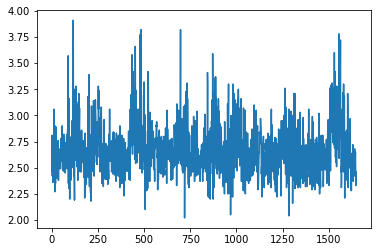

In [417]:
characteristics["average_household_size"].plot()

### Data Var Names
* n_ibuyers
* gdp
* inc X
* pop_info
* h_vals
* educ
* wages
* characteristics

In [418]:
all_dfs = [n_ibuyers, gdp, inc, pop_info, h_vals, educ, wages, characteristics]

In [419]:
def cust_merge(df1, df2):
    return df1.pipe(
    pd.merge, 
    df2, 
    on=["state", "county", "year"], 
    how="inner"
)

In [420]:
merged = n_ibuyers.pipe(
    pd.merge, 
    characteristics, 
    on=["state", "county", "year"], 
    how="right"
)

merged[["ntop_ibs", "nlocal_ibs", "treatment"]] = merged[["ntop_ibs", "nlocal_ibs", "treatment"]].fillna(0)

merged

,county,state,year,ntop_ibs,nlocal_ibs,treatment,9th_to_12th_grade_no_diploma,associates_degree,bachelors_degree,graduate_or_professional_degree,...,1_unit_attached,1_unit_detached,2_units,20_or_more_units,3_or_4_units,5_to_9_units,boat_rv_van_etc_,mobile_home,average_household_size,state_full
0,lasalle,il,2016,0.0,0.0,0.0,35.1,12.2,6.8,88.5,...,2.0,79.3,4.8,2.5,4.3,2.8,0.0,2.7,2.47,illinois
1,mchenry,il,2016,0.0,0.0,0.0,26.5,23.4,10.3,92.6,...,9.8,76.5,1.8,2.6,2.3,4.6,0.0,0.5,2.81,illinois
2,mclean,il,2016,0.0,0.0,0.0,25.1,27.4,16.5,96.9,...,4.7,62.1,3.1,7.5,3.6,6.0,0.0,4.6,2.67,illinois
3,macon,il,2016,0.0,0.0,0.0,34.0,13.0,8.6,89.5,...,1.8,77.4,1.3,5.8,2.5,4.9,0.0,2.8,2.42,illinois
4,madison,il,2016,0.0,0.0,0.0,28.8,16.5,9.9,92.5,...,2.3,78.7,3.0,2.7,4.9,2.9,0.0,2.7,2.56,illinois
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644,waukesha,wi,2019,0.0,0.0,0.0,2.3,9.6,30.2,15.9,...,6.2,69.6,2.2,9.6,2.7,5.4,0.0,0.7,2.65,wisconsin
1645,winnebago,wi,2019,0.0,0.0,0.0,5.6,10.1,22.2,8.9,...,4.2,63.4,5.4,6.8,4.3,8.4,0.0,2.7,2.47,wisconsin
1646,wood,wi,2019,0.0,0.0,0.0,6.1,12.8,12.7,7.0,...,1.6,75.2,5.9,7.3,1.9,2.4,0.0,3.4,2.33,wisconsin
1647,laramie,wy,2019,0.0,0.0,0.0,3.2,11.5,17.8,12.3,...,10.7,63.3,2.1,5.0,7.0,3.5,0.2,6.7,2.46,wyoming


In [421]:
merged = merged.pipe(cust_merge, gdp)
merged

,county,state,year,ntop_ibs,nlocal_ibs,treatment,9th_to_12th_grade_no_diploma,associates_degree,bachelors_degree,graduate_or_professional_degree,...,wholesale_trade,private_industries,all_industry_total,government_and_government_enterprises,manufacturing_and_information,natural_resources_and_mining,private_goods_producing_industries_2/,private_services_providing_industries_3/,trade,transportation_and_utilities
0,lasalle,il,2016,0.0,0.0,0.0,35.1,12.2,6.8,88.5,...,316796,4939084,5381397,443350,948199,373865,1405277,3529858,649351,1257612
1,mchenry,il,2016,0.0,0.0,0.0,26.5,23.4,10.3,92.6,...,692063,9204255,10320051,1118218,2631731,0,0,0,1524474,0
2,mclean,il,2016,0.0,0.0,0.0,25.1,27.4,16.5,96.9,...,566569,12282168,13291312,1022921,458150,455800,936471,11336218,1090904,254971
3,macon,il,2016,0.0,0.0,0.0,34.0,13.0,8.6,89.5,...,0,6523392,6939925,417736,3060609,272613,3414658,3111205,0,460910
4,madison,il,2016,0.0,0.0,0.0,28.8,16.5,9.9,92.5,...,623443,9438372,10554729,1118111,2628118,34108,3123947,6216006,1355298,649909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1597,waukesha,wi,2019,0.0,0.0,0.0,2.3,9.6,30.2,15.9,...,2450741,26357198,27749480,1403750,7242847,164172,7418462,18942231,4214611,643736
1598,winnebago,wi,2019,0.0,0.0,0.0,5.6,10.1,22.2,8.9,...,0,8909760,9725443,820622,3179283,0,0,0,0,0
1599,wood,wi,2019,0.0,0.0,0.0,6.1,12.8,12.7,7.0,...,145405,3377667,3708760,333326,967891,54235,861176,2519889,366167,327351
1600,laramie,wy,2019,0.0,0.0,0.0,3.2,11.5,17.8,12.3,...,153690,3787042,5272539,1490874,680808,0,0,0,542754,0


In [422]:
#merged = merged.pipe(cust_merge, inc)
#merged

In [423]:
merged = merged.pipe(cust_merge, pop_info)
merged

,county,state,year,ntop_ibs,nlocal_ibs,treatment,9th_to_12th_grade_no_diploma,associates_degree,bachelors_degree,graduate_or_professional_degree,...,manufacturing_and_information,natural_resources_and_mining,private_goods_producing_industries_2/,private_services_providing_industries_3/,trade,transportation_and_utilities,popestimate,rnaturalinc,rnetmig,state_full_y
0,lasalle,il,2016,0.0,0.0,0.0,35.1,12.2,6.8,88.5,...,948199,373865,1405277,3529858,649351,1257612,110215,-0.497211,-6.762071,illinois
1,mchenry,il,2016,0.0,0.0,0.0,26.5,23.4,10.3,92.6,...,2631731,0,0,0,1524474,0,307159,3.686165,-5.046110,illinois
2,mclean,il,2016,0.0,0.0,0.0,25.1,27.4,16.5,96.9,...,458150,455800,936471,11336218,1090904,254971,173070,5.210695,-5.655511,illinois
3,macon,il,2016,0.0,0.0,0.0,34.0,13.0,8.6,89.5,...,3060609,272613,3414658,3111205,0,460910,106383,1.122933,-10.134471,illinois
4,madison,il,2016,0.0,0.0,0.0,28.8,16.5,9.9,92.5,...,2628118,34108,3123947,6216006,1355298,649909,265641,1.004445,-2.291037,illinois
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1617,waukesha,wi,2019,0.0,0.0,0.0,2.3,9.6,30.2,15.9,...,7242847,164172,7418462,18942231,4214611,643736,404198,0.654502,3.597283,wisconsin
1618,winnebago,wi,2019,0.0,0.0,0.0,5.6,10.1,22.2,8.9,...,3179283,0,0,0,0,0,171907,1.668684,4.364252,wisconsin
1619,wood,wi,2019,0.0,0.0,0.0,6.1,12.8,12.7,7.0,...,967891,54235,861176,2519889,366167,327351,72999,1.014025,-0.342576,wisconsin
1620,laramie,wy,2019,0.0,0.0,0.0,3.2,11.5,17.8,12.3,...,680808,0,0,0,542754,0,99500,3.982557,2.450029,wyoming


In [424]:
merged = merged.pipe(cust_merge, h_vals)
merged

,county,state,year,ntop_ibs,nlocal_ibs,treatment,9th_to_12th_grade_no_diploma,associates_degree,bachelors_degree,graduate_or_professional_degree,...,median_listing_price,active_listing_count,median_days_on_market,new_listing_count,price_increased_count,price_reduced_count,median_square_feet,average_listing_price,total_listing_count,pending_ratio
0,mchenry,il,2016,0.0,0.0,0.0,26.5,23.4,10.3,92.6,...,269050.0,2199,59.0,720,8,808,2260.0,314846,3422,0.5562
1,mclean,il,2016,0.0,0.0,0.0,25.1,27.4,16.5,96.9,...,149950.0,998,64.0,264,4,348,2480.0,200383,1426,0.4289
2,macon,il,2016,0.0,0.0,0.0,34.0,13.0,8.6,89.5,...,99950.0,549,66.0,116,4,152,1744.0,137158,558,0.0164
3,madison,il,2016,0.0,0.0,0.0,28.8,16.5,9.9,92.5,...,120050.0,1475,76.0,384,4,412,1489.0,201320,2003,0.3580
4,peoria,il,2016,0.0,0.0,0.0,26.5,19.2,11.5,90.5,...,137550.0,1473,66.0,356,8,484,1858.0,195763,1760,0.1948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604,waukesha,wi,2019,0.0,0.0,0.0,2.3,9.6,30.2,15.9,...,439995.0,884,82.5,332,4,160,2405.0,555043,1195,0.3518
1605,winnebago,wi,2019,0.0,0.0,0.0,5.6,10.1,22.2,8.9,...,182450.0,362,92.5,128,0,44,1717.0,285769,532,0.4696
1606,wood,wi,2019,0.0,0.0,0.0,6.1,12.8,12.7,7.0,...,149950.0,288,110.0,48,0,28,1717.5,177417,298,0.0347
1607,laramie,wy,2019,0.0,0.0,0.0,3.2,11.5,17.8,12.3,...,290800.0,283,60.0,120,4,44,2486.0,330254,519,0.8339


In [425]:
merged = merged.pipe(cust_merge, educ)
merged

,county,state,year,ntop_ibs,nlocal_ibs,treatment,9th_to_12th_grade_no_diploma,associates_degree,bachelors_degree,graduate_or_professional_degree,...,median_days_on_market,new_listing_count,price_increased_count,price_reduced_count,median_square_feet,average_listing_price,total_listing_count,pending_ratio,math_prof_pct,english_prof_pct
0,mchenry,il,2016,0.0,0.0,0.0,26.5,23.4,10.3,92.6,...,59.0,720,8,808,2260.0,314846,3422,0.5562,38.266964,45.191964
1,mclean,il,2016,0.0,0.0,0.0,25.1,27.4,16.5,96.9,...,64.0,264,4,348,2480.0,200383,1426,0.4289,39.317100,43.870942
2,macon,il,2016,0.0,0.0,0.0,34.0,13.0,8.6,89.5,...,66.0,116,4,152,1744.0,137158,558,0.0164,27.992347,34.375000
3,madison,il,2016,0.0,0.0,0.0,28.8,16.5,9.9,92.5,...,76.0,384,4,412,1489.0,201320,2003,0.3580,24.251374,28.949405
4,peoria,il,2016,0.0,0.0,0.0,26.5,19.2,11.5,90.5,...,66.0,356,8,484,1858.0,195763,1760,0.1948,33.450280,39.389181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1603,waukesha,wi,2019,0.0,0.0,0.0,2.3,9.6,30.2,15.9,...,82.5,332,4,160,2405.0,555043,1195,0.3518,63.082798,58.103274
1604,winnebago,wi,2019,0.0,0.0,0.0,5.6,10.1,22.2,8.9,...,92.5,128,0,44,1717.0,285769,532,0.4696,45.200000,43.350000
1605,wood,wi,2019,0.0,0.0,0.0,6.1,12.8,12.7,7.0,...,110.0,48,0,28,1717.5,177417,298,0.0347,37.281250,40.645833
1606,laramie,wy,2019,0.0,0.0,0.0,3.2,11.5,17.8,12.3,...,60.0,120,4,44,2486.0,330254,519,0.8339,47.250000,52.062500


In [426]:
merged = merged.pipe(cust_merge, wages)
merged

,county,state,year,ntop_ibs,nlocal_ibs,treatment,9th_to_12th_grade_no_diploma,associates_degree,bachelors_degree,graduate_or_professional_degree,...,english_prof_pct,area_fips,annual_avg_estabs,annual_avg_emplvl,total_annual_wages,taxable_annual_wages,annual_contributions,annual_avg_wkly_wage,avg_annual_pay,state_full
0,mchenry,il,2016,0.0,0.0,0.0,26.5,23.4,10.3,92.6,...,45.191964,17111,8587,96943,4267915417,1090558698,32010259,847,44025,illinois
1,mclean,il,2016,0.0,0.0,0.0,25.1,27.4,16.5,96.9,...,43.870942,17113,3706,83683,4291447023,895499624,21774601,986,51282,illinois
2,macon,il,2016,0.0,0.0,0.0,34.0,13.0,8.6,89.5,...,34.375000,17115,2388,49393,2407471815,523271866,16846316,937,48741,illinois
3,madison,il,2016,0.0,0.0,0.0,28.8,16.5,9.9,92.5,...,28.949405,17119,5874,97974,4077139012,1057630558,37912243,800,41615,illinois
4,peoria,il,2016,0.0,0.0,0.0,26.5,19.2,11.5,90.5,...,39.389181,17143,4499,100458,5125781077,943347266,35397255,981,51024,illinois
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1623,waukesha,wi,2019,0.0,0.0,0.0,2.3,9.6,30.2,15.9,...,58.103274,55133,13594,246034,14328051026,3284415924,55787780,1120,58236,wisconsin
1624,winnebago,wi,2019,0.0,0.0,0.0,5.6,10.1,22.2,8.9,...,43.350000,55139,3908,93007,5041362734,1111229096,17107933,1042,54204,wisconsin
1625,wood,wi,2019,0.0,0.0,0.0,6.1,12.8,12.7,7.0,...,40.645833,55141,2042,38719,1780384733,397254003,6249876,884,45982,wisconsin
1626,laramie,wy,2019,0.0,0.0,0.0,3.2,11.5,17.8,12.3,...,52.062500,56021,3782,46846,2285702712,775049974,8906341,938,48791,wyoming


## Post-Merge Processing

In [427]:
def conv_to_int(x):
    if isinstance(x, str):
        x = (
            x \
            .replace(",", "")
        )
    try:
        return float(x)
    except ValueError:
        return np.nan
        
numeric_cols = [col for col in merged.columns if col not in ["county", "state", "year", "city", "state_full"]]
merged[numeric_cols] = merged[numeric_cols].apply(lambda x: x.apply(conv_to_int))
merged = merged.groupby(["county", "state", "year"]).mean().reset_index()
merged

,county,state,year,ntop_ibs,nlocal_ibs,treatment,9th_to_12th_grade_no_diploma,associates_degree,bachelors_degree,graduate_or_professional_degree,...,math_prof_pct,english_prof_pct,area_fips,annual_avg_estabs,annual_avg_emplvl,total_annual_wages,taxable_annual_wages,annual_contributions,annual_avg_wkly_wage,avg_annual_pay
0,ada,id,2016,0.0,0.0,1.0,22.5,26.0,12.1,95.2,...,45.758471,57.353316,16001.0,14927.0,226196.0,1.040892e+10,4.876201e+09,56513290.0,885.0,46017.0
1,ada,id,2019,0.0,2.0,1.0,3.8,10.4,25.4,14.3,...,42.856647,57.032407,16001.0,16442.0,252953.0,1.314580e+10,6.155561e+09,42858366.0,999.0,51969.0
2,adams,co,2016,0.0,0.0,1.0,29.1,15.8,7.1,82.8,...,21.781656,30.250000,8001.0,10394.0,198368.0,1.015594e+10,2.256437e+09,50351378.0,985.0,51197.0
3,adams,co,2019,0.0,15.0,1.0,9.0,8.6,17.1,8.3,...,23.689123,37.159091,8001.0,11630.0,225848.0,1.279172e+10,2.796571e+09,43959576.0,1089.0,56639.0
4,adams,il,2016,0.0,0.0,0.0,34.7,16.3,9.0,91.7,...,27.395833,32.662500,17001.0,1812.0,32322.0,1.280316e+09,3.249157e+08,7342135.0,762.0,39612.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,york,sc,2019,0.0,0.0,0.0,4.9,10.1,22.5,12.6,...,51.645833,53.187500,45091.0,6450.0,100346.0,4.785245e+09,1.319552e+09,18312741.0,917.0,47688.0
1580,yuba,ca,2016,0.0,0.0,0.0,23.0,13.8,4.8,84.4,...,31.663393,45.042262,6115.0,1602.0,16685.0,7.989854e+08,7.560441e+07,3667830.0,921.0,47885.0
1581,yuba,ca,2019,0.0,0.0,0.0,12.4,10.0,13.1,4.8,...,34.841518,43.536905,6115.0,1694.0,18564.0,9.871101e+08,9.327558e+07,4035971.0,1023.0,53173.0
1582,yuma,az,2016,0.0,0.0,0.0,26.6,10.2,5.2,74.2,...,32.534960,34.208971,4027.0,3156.0,66432.0,2.379464e+09,5.010725e+08,24659203.0,689.0,35818.0


In [428]:
# check to make sure treatment observations after treatment have at least one iBuyer
merged.query("treatment==1 & year==2019")[["ntop_ibs", "nlocal_ibs"]].sum(axis=1).apply(lambda x: x==0).sum()

0

In [429]:
# dict with format (str new_col): (list agg_cols, (pd.Series *agg_func)(pd.DataFrame))
bin_dict = {   
    "move_post2010": (["moved_in_2010_to_2014", "moved_in_2015_or_later"], np.sum),
    "educ_nohs": (["less_than_9th_grade", "9th_to_12th_grade_no_diploma"], np.sum),
    "educ_further": (["associates_degree", "bachelors_degree", "graduate_or_professional_degree"], np.sum)
}

for new_col, (cols, f) in bin_dict.items():
    merged[new_col] = merged[cols].agg(f, axis=1)
    merged.drop(columns=cols, inplace=True)
    
merged

,county,state,year,ntop_ibs,nlocal_ibs,treatment,high_school_graduate_includes_equivalency,some_college_no_degree,married_couple_family,with_own_children_of_the_householder_under_18_years,...,annual_avg_estabs,annual_avg_emplvl,total_annual_wages,taxable_annual_wages,annual_contributions,annual_avg_wkly_wage,avg_annual_pay,move_post2010,educ_nohs,educ_further
0,ada,id,2016,0.0,0.0,1.0,23.5,11.1,63.7,26.8,...,14927.0,226196.0,1.040892e+10,4.876201e+09,56513290.0,885.0,46017.0,50.5,26.0,133.3
1,ada,id,2019,0.0,2.0,1.0,19.8,24.9,53.5,22.5,...,16442.0,252953.0,1.314580e+10,6.155561e+09,42858366.0,999.0,51969.0,49.4,5.2,50.1
2,adams,co,2016,0.0,0.0,1.0,21.7,9.0,70.3,35.8,...,10394.0,198368.0,1.015594e+10,2.256437e+09,50351378.0,985.0,51197.0,56.3,38.5,105.7
3,adams,co,2019,0.0,15.0,1.0,29.8,21.0,51.8,23.7,...,11630.0,225848.0,1.279172e+10,2.796571e+09,43959576.0,1089.0,56639.0,45.7,15.1,34.0
4,adams,il,2016,0.0,0.0,0.0,24.3,7.3,67.3,27.8,...,1812.0,32322.0,1.280316e+09,3.249157e+08,7342135.0,762.0,39612.0,41.9,41.3,117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,york,sc,2019,0.0,0.0,0.0,23.9,23.8,48.6,19.5,...,6450.0,100346.0,4.785245e+09,1.319552e+09,18312741.0,917.0,47688.0,42.2,7.2,45.2
1580,yuba,ca,2016,0.0,0.0,0.0,31.8,11.0,70.6,35.9,...,1602.0,16685.0,7.989854e+08,7.560441e+07,3667830.0,921.0,47885.0,57.6,33.0,103.0
1581,yuba,ca,2019,0.0,0.0,0.0,25.6,27.6,50.3,24.2,...,1694.0,18564.0,9.871101e+08,9.327558e+07,4035971.0,1023.0,53173.0,44.1,19.1,27.9
1582,yuma,az,2016,0.0,0.0,0.0,26.3,5.8,72.7,30.9,...,3156.0,66432.0,2.379464e+09,5.010725e+08,24659203.0,689.0,35818.0,49.2,37.6,89.6


In [430]:
merged_std = merged.copy()
for col in (set(merged_std.columns) - set(["county", "state", "year", "ntop_ibs", "nlocal_ibs", "treatment", "median_listing_price", "median_days_on_market"])):
    s = merged_std[col]
    merged_std[col] = (merged_std[col] - s.mean())
    
merged_std

,county,state,year,ntop_ibs,nlocal_ibs,treatment,high_school_graduate_includes_equivalency,some_college_no_degree,married_couple_family,with_own_children_of_the_householder_under_18_years,...,annual_avg_estabs,annual_avg_emplvl,total_annual_wages,taxable_annual_wages,annual_contributions,annual_avg_wkly_wage,avg_annual_pay,move_post2010,educ_nohs,educ_further
0,ada,id,2016,0.0,0.0,1.0,-1.760764,-3.86351,6.302431,4.065076,...,5008.970013,71846.513573,1.468770e+09,3.105382e+09,1.827444e+07,-23.813131,-1241.769571,7.197348,2.866351,54.667203
1,ada,id,2019,0.0,2.0,1.0,-5.460764,9.93649,-3.897569,-0.234924,...,6523.970013,98603.513573,4.205652e+09,4.384741e+09,4.619516e+06,90.186869,4710.230429,6.097348,-17.933649,-28.532797
2,adams,co,2016,0.0,0.0,1.0,-3.560764,-5.96351,12.902431,13.065076,...,475.970013,44018.513573,1.215788e+09,4.856174e+08,1.211253e+07,76.186869,3938.230429,12.997348,15.366351,27.067203
3,adams,co,2019,0.0,15.0,1.0,4.539236,6.03649,-5.597569,0.965076,...,1711.970013,71498.513573,3.851576e+09,1.025751e+09,5.720726e+06,180.186869,9380.230429,2.397348,-8.033649,-44.632797
4,adams,il,2016,0.0,0.0,0.0,-0.960764,-7.66351,9.902431,5.065076,...,-8106.029987,-122027.486427,-7.659831e+09,-1.445904e+09,-3.089672e+07,-146.813131,-7646.769571,-1.402652,18.166351,38.367203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,york,sc,2019,0.0,0.0,0.0,-1.360764,8.83649,-8.797569,-3.234924,...,-3468.029987,-54003.486427,-4.154902e+09,-4.512673e+08,-1.992611e+07,8.186869,429.230429,-1.102652,-15.933649,-33.432797
1580,yuba,ca,2016,0.0,0.0,0.0,6.539236,-3.96351,13.202431,13.165076,...,-8316.029987,-137664.486427,-8.141162e+09,-1.695215e+09,-3.457102e+07,12.186869,626.230429,14.297348,9.866351,24.367203
1581,yuba,ca,2019,0.0,0.0,0.0,0.339236,12.63649,-7.097569,1.465076,...,-8224.029987,-135785.486427,-7.953037e+09,-1.677544e+09,-3.420288e+07,114.186869,5914.230429,0.797348,-4.033649,-50.732797
1582,yuma,az,2016,0.0,0.0,0.0,1.039236,-9.16351,15.302431,8.165076,...,-6762.029987,-87917.486427,-6.560683e+09,-1.269747e+09,-1.357965e+07,-219.813131,-11440.769571,5.897348,14.466351,10.967203


In [431]:
merged.to_csv("data/processed/merged.csv", index=False)
merged_std.to_csv("data/processed/merged_std.csv", index=False)

## Post-Processing EDA

In [196]:
merged.query("treatment <= 1")[["county", "state"]].drop_duplicates()

,county,state
0,ada,id
2,adams,co
4,adams,il
6,adams,pa
8,aiken,sc
...,...,...
1574,york,me
1576,york,pa
1578,york,sc
1580,yuba,ca


In [197]:
len(all_dfs)

8

In [169]:
def find_col_df(col):
    matches = []
    if isinstance(col, tuple):
        col = col[0]
    for df in all_dfs:
        if col in df.columns:
            name = None
            var = None
            for name, var in globals().items():
                if var is df:
                    matches.append(name)
    return matches[:-1]

In [211]:
all_cols =[
    "median_listing_price",
    "median_days_on_market",
    "median_rooms", 
    "homeowner_vacancy_rate", 
    "mean_travel_time_to_work_minutes", 
    "math_prof_pct", 
    "english_prof_pct", 
    "median_square_feet", 
    "median_age_years", 
    ("moved_in_2010_to_2014", "move_post2010"),
    "annual_avg_emplvl", 
    "median_household_income_dollars", 
    "per_capita_income_dollars", 
    "popestimate", 
    "rnaturalinc", 
    "rnetmig", 
    ("less_than_9th_grade", "educ_nohs"),
    ("associates_degree", "part of educ_further"),
    "average_household_size", 
    "white", 
    "mean_cash_public_assistance_income_dollars", 
    "construction", 
    "mean_retirement_income_dollars", 
    "ntop_ibs",
    "nlocal_ibs"
]

In [202]:
find_col_df("median_listing_price")

['h_vals']

In [203]:
len(all_cols)

24

In [204]:
{elem[0] for elem in [find_col_df(name) for name in all_cols] if len(elem)>0}

{'characteristics', 'educ', 'gdp', 'h_vals', 'n_ibuyers', 'pop_info', 'wages'}

In [213]:
col1 = []
col2 = []
for name in all_cols:
    col1.append(name[1] if isinstance(name, tuple) else name)
    col2.append(find_col_df(name)[0])
    
regressors = pd.DataFrame({"regressor_name":col1, "dataset":col2}).sort_values("dataset")
regressors

,regressor_name,dataset
12,per_capita_income_dollars,characteristics
22,mean_retirement_income_dollars,characteristics
2,median_rooms,characteristics
3,homeowner_vacancy_rate,characteristics
4,mean_travel_time_to_work_minutes,characteristics
8,median_age_years,characteristics
9,move_post2010,characteristics
20,mean_cash_public_assistance_income_dollars,characteristics
11,median_household_income_dollars,characteristics
19,white,characteristics


In [217]:
regressors.query("dataset == 'characteristics'").shape

(13, 2)

In [214]:
regressors.to_latex(
    index=False, 
    caption="Dataset of Origin of Selected Regressors",
    label="regressor_origin"
)

'\\begin{table}\n\\centering\n\\caption{Dataset of Origin of Selected Regressors}\n\\label{regressor_origin}\n\\begin{tabular}{ll}\n\\toprule\n                             regressor\\_name &          dataset \\\\\n\\midrule\n                  per\\_capita\\_income\\_dollars &  characteristics \\\\\n             mean\\_retirement\\_income\\_dollars &  characteristics \\\\\n                               median\\_rooms &  characteristics \\\\\n                     homeowner\\_vacancy\\_rate &  characteristics \\\\\n           mean\\_travel\\_time\\_to\\_work\\_minutes &  characteristics \\\\\n                           median\\_age\\_years &  characteristics \\\\\n                              move\\_post2010 &  characteristics \\\\\n mean\\_cash\\_public\\_assistance\\_income\\_dollars &  characteristics \\\\\n            median\\_household\\_income\\_dollars &  characteristics \\\\\n                                      white &  characteristics \\\\\n                     average\\_hous

In [375]:
find_col = lambda df, name: [col for col in df.columns if name in col]

In [160]:
find_col(characteristics, "median_age")

['median_age_years']

## ========== DEBUG START ============

In [44]:
# debug tool to gague match diversion between treatment counties and gathered data

dbg_df = pd.DataFrame() # gathered data dataframe

dbg_col = "" # any column in dbg_df with no missing values

In [22]:
dbg_df[""]

0       al
1       al
2       al
3       al
4       al
        ..
4815    sd
4816    sd
4817    sd
4818    sd
4819    sd
Name: state, Length: 4820, dtype: object

In [23]:
dbg_df.pipe(in_col, "county", "")#.query("state == 'ny'")

,county,violent_crime,murder_and_nonnegligent_manslaughter,rape,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,state,arson,year,state_full
2426,worcester,13.0,2.0,2.0,5.0,4.0,249.0,63.0,178.0,8.0,md,0.0,2016,maryland
4564,worcester,15.0,0.0,4.0,2.0,9.0,248.0,33.0,207.0,8.0,md,1.0,2019,maryland


In [24]:
dbg_df.pipe(merge_ibs, debug=dbg_col).query("year == '2016'")

KeyError: "['city'] not in index"

## ========== DEBUG END ============